In [1]:
# Import the necessary dependencies

# Operating System
import os
import gc

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LightFM
from lightfm import LightFM
from lightfm.data import Dataset as lfmDataset 

# Surprise
from surprise import SVD
from surprise import Dataset as sDataset
from surprise import Reader

# Model Evaluation
from evaluation import evaluate_solution

# RAM control
from ramcontrol import check_memory_limit, memory_circuit_breaker

### Attention: The data used in this notebook can be enough to fill your PC's RAM. To prevent you PC from turning to a bonfire, there are some steps that can be taken:

<img src="./media/burning_pc.gif" width="450"/>

 - On cells that consume a lot of RAM, stop execution if RAM usage is too high. This can be done with function `memory_circuit_breaker`. This function checks if the total computer RAM usage percentage is above a threshold and if it can't lower it, it stops execution. You can control the percentage with `memory_limit_perc` below.
 - Frequently delete useless objects along the notebook. If a dataframe or matrix is not going to be used further below a given cell, then we can delete that object and let the garbage collection clear some RAM.
 - Change the data types to lighter alternatives: integer IDs can be converted to strings, numerical values can have smaller "bitness" but be on the lookout for [overflow errors](https://numpy.org/doc/stable/user/basics.types.html#overflow-errors) (for example: using `np.float32` instead of `np.float64`), removed unused features early, etc.
 - If RAM is still an issue at this point, we can subset the original dataset to work with a smaller fraction of the data. Of course, this will impact the quality of your models and recommendations, but if it necessary to follow the notebook then subset the data.
 - When you execute cells multiple times, there might happen that the memory increases at each execution, even if no new objects or data is generated. If that's the case, you should restart the kernel and re-execute the cells.
 - Ultimately, you may need more RAM. ¯\\_(ツ)_/¯

In [2]:
# limit of total memory percentage that be used [0.,100.]
memory_limit_perc = 90.

# BLU12 - Learning Notebook - Workflow
## Introduction
This week, we are going to simulate the real-life environment of the Hackathon! We will provide you with a dataset, some tips and you are going to train, validate and predict with a Recommender System using all the knowledge acquired throughout this specialization.

## Context
You have finished the Academy and you are hired as a Data Scientist in Recommenu. Recommenu is a disruptive crowdsourcing peer-to-peer mobile app experience developed to deliver an unique environment especially designed for maximum enjoyment by empowering users to engage in recipe sharing and reviewing in a paradigm shift block-chain powered AI platform.

<img src="./media/recommenu_logo.png" width="500"/>

First week on the job and the CEO of the next-unicorn-startup that hired you pitches your first task for the company: build a recommender system to suggest users what they should prepare for their next meals. Your recommendations should be based on their reviews but also on the reviews of other users.

He doesn't care how you do it or how it works, just that you use fancy trendy eye-catching mind-blowing AI *stuff* to promote Recommenu's name in the Data Science industry.

## Technical Task
After the pitch from the CEO, you talk with your Lead Data Scientist and you get the tasks needed to fulfill the job. The company collected some data on the users and recipes, you will need to create the recommender system that is effective enough so that your users will always know what to cook. The main task is to find the best recommendations for each user.

## Evaluation

Your Lead DS will keep some of the data as a test dataset (in which you will estimate production performance) and gives you the remaining data for yourself.

The expected output is 50 recommendations for each user. The recommendations are compared with the test dataset and evaluated using map@50.

Review the `example_out.csv` file to know the expected output format. 

## Step -1: Avaliable data
You have available under the `./data/` folder some files that you can use for building the recommender system. As a good scientist, the first step is to validate that the data you have will be good enough to proceed.

The files we have available for the **training** stage are:
* `interactions_train.csv` has the users' review history training data
* `RAW_recipes.csv`: has the all recipes' metadata information


For the **test** stage, we have:
* `test_users.csv`: has the users' ID to recommend recipes
* `example_output.csv`: has an example of an output (just for a couple of users)

The best approach is to look at the raw files and print out the first rows of each file just to get a overall sense of what we have.

*Note*: since the `RAW_recipes.csv` is heavy, it was stored in a zip file which you will need to unzip first.

*Note for Windows users: remember that you need to convert the head command into the Windows equivalent. Tip: you can use what you learned in Data Wrangling Learning Unit!*

In [3]:
print("RAW_interactions_train.csv \n")
!head -3 data/RAW_interactions_train.csv

RAW_interactions_train.csv 

user_id,recipe_id,review_date,rating,comment
2133146,40767,2012-01-03,0,"i'm yet to try this recipe but my dad makes one very similar. it's definitely sweetened condensed milk (because its thick and sugary), and the sugar has to be simmered until its melted completely. my father also used golden syrup on top of the ingredients listed here. you can also add a small portion of water once the ingredients are thoroughly combined and sugar melted and place back on low heat to thicken up again"
1619510,169999,2011-06-18,5,"Made this many times, absolutly love it. Like my corn on the raw side took kpfen advise and only cooked it for 15 minutes...."


In [4]:
print("RAW_recipes.csv\n")
!head -2 data/RAW_recipes.csv

RAW_recipes.csv

name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
bananas 4 ice cream  pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'pies-and-tarts', 'desserts', 'lunch', 'snacks', 'no-cook', 'refrigerator', 'kid-friendly', 'frozen-desserts', 'pies', 'chocolate', 'dietary', 'inexpensive', 'equipment', 'number-of-servings', 'technique', '4-hours-or-less']","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 220.0]",8,"['crumble cookies into a 9-inch pie plate , or cake pan', 'pat down to form an even layer', 'drizzle 1 cup of chocolate topping evenly over the cookies with a small spoon', 'scoop the vanilla ice cream on top of the chocolate and smooth down', 'cover with half of the sliced bananas', 'top with strawberry ice cream', 'cover and freeze until firm', 'before serving , top with 1 / 4 cup chocolate topping , whipped cream , and sliced bananas']",,"['chocolate sandwi

In [5]:
print("test_users.csv \n")
!head -10 data/test_users.csv

test_users.csv 

user_id
1535
2310
2312
3288
4291
4439
4470
4740
5060


In [6]:
print("example_output.csv \n")
!head -1 data/example_output.csv

example_output.csv 




## Step 0: Load the Data
After validating that the data we have is good enough, we start with building the ratings matrix. Our strategy for the first model is to get a non-personalized system as a baseline. This allows us to both predict for existing users (no cold-start problem) and for new users.

## Step 0.1: Load the interaction file

In [7]:
train_path = os.path.join('data', 'RAW_interactions_train.csv')
data = pd.read_csv(train_path)
data.head()

,user_id,recipe_id,review_date,rating,comment
0,2133146,40767,2012-01-03,0,i'm yet to try this recipe but my dad makes on...
1,1619510,169999,2011-06-18,5,"Made this many times, absolutly love it. Like ..."
2,1072593,111434,2014-08-07,5,The family&#039;s divided on this one. The ra...
3,72489,15059,2004-12-20,5,C'est si bon! These are delicious and delecta...
4,109110,336205,2013-06-10,0,This wasn&#039;t to our taste.


## Step 0.2: Load the recipes' metadata file

In [8]:
recipe_meta_path = os.path.join('data', 'RAW_recipes.csv')
recipes = pd.read_csv(recipe_meta_path)
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6
1,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9
2,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7
3,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13
4,chinese candy,23933,15,35268,2002-03-29,"['15-minutes-or-less', 'time-to-make', 'course...","[232.7, 21.0, 77.0, 4.0, 6.0, 38.0, 8.0]",4,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...","['butterscotch chips', 'chinese noodles', 'sal...",3


## Step 0.3: Load test users file

In [9]:
test_user_path = os.path.join('data', 'test_users.csv')
test_users = pd.read_csv(test_user_path)
test_users.head()

,user_id
0,1535
1,2310
2,2312
3,3288
4,4291


It will be useful later on to have a list of test data users:

In [10]:
users_test = list(test_users["user_id"].unique())
print(f"We are recommending recipes for {len(users_test)} users.")

We are recommending recipes for 889 users.


## Step 1: Interaction data exploration

Let's explore the interaction data.

In [11]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data):,} ratings in total.")

We have 163,065 ratings in total.


In [12]:
# How many recipes were rated?
print(f" We have {data['recipe_id'].unique().size:,} recipes rated.")

 We have 30,695 recipes rated.


In [13]:
# How many users rated at least one recipe?
print(f" We have {data['user_id'].unique().size:,} users that rated at least one recipe.")

 We have 58,884 users that rated at least one recipe.


Let's plot the rating distribution:

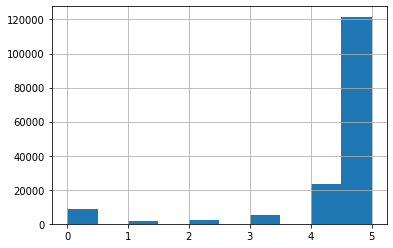

In [14]:
# Plotting the rating distribution.
data["rating"].hist();

There are ratings with value 0. We expected the values to be between 1 and 5. Let's check these cases.

In [15]:
data.loc[data["rating"] == 0][80:120]

,user_id,recipe_id,review_date,rating,comment
1560,2002194880,36431,2018-06-22,0,How do you store them after they are done? Wha...
1584,2002171413,449747,2018-05-31,0,Cook uncovered and in a low pan (use a good qu...
1600,162285,103281,2005-02-21,0,I am from Bavaria and my mom used to make it a...
1670,2164272,411501,2017-03-06,0,I am so excited!!! Shawn can't wait for me to ...
1674,1759082,15411,2010-12-15,0,"Quick, Easy, & using ingredients that you ALWA..."
1676,2001467157,48635,2017-04-01,0,Do I have to use the baking soda???
1678,111336,693,2005-08-24,0,"Easy, quick ""hot dish""."
1683,261899,211710,2012-10-14,0,My family loved this..So tonight I'm trying wi...
1698,2206320,475041,2012-03-12,0,That sounds yummy!!!
1701,159782,334688,2011-01-18,0,"Well, it doesn't get much easier than this. Ad..."


When rating is 0, it seems that some comments are negative but most are positive. Let's read some examples.

In [16]:
data.loc[data["rating"] == 0, "comment"][1917]

'WOW...This was incredible, I wish I could give a hundred stars. My Boyfriend said we would never eat out Mexican again. So five stars from him and five from me...my daughter even ate every bite! This is a great recipe. I of course added just a little spice, 1 Tbsp of cumin to the chicken and onions. Perfect recipe, the sauce is beautiful when it comes together, Everything was perfect. Thank you for sharing!'

In [17]:
data.loc[data["rating"] == 0, "comment"][1732]

'Seriously? The worst recipe ever!! Made it yesterday. Never ever experienced such a worse mac n cheese sauce:-(\nTotal flour taste! Like sb else already noticed: your family will hate you for that.\nGoing to find me another recipe now or have to stick to the craft company.'

In [18]:
data.loc[data["rating"] == 0, "comment"][2054]

'Great recipe!!! Super easy & quick & DELICIOUS!!! My family loved it!!!'

In [19]:
data.loc[data["rating"] == 0, "comment"][1768]

'How much water should I add?'

In [20]:
data.loc[data["rating"] == 0, "comment"][2192]

"I can't rate this yet.  Unfortunately, my crock pot died while making and by the time I found out I had to dump the whole thing for safety reasons.  I did try remaking but having less wine (using 1/2 wine, half homemade beef broth) it wouldn't be fair to rate.  I'm so sorry, Chohettz.  \r\nMade for PAC, 2008."

While some comments are positive, others are negative. Additionally, it appears that some user commented that they didn't rate the recipe. Let's see if there are more cases.

In [21]:
data.loc[(data["rating"] == 0) & (data["comment"].str.contains("rate"))].head()

,user_id,recipe_id,review_date,rating,comment
58,441655,443523,2010-12-07,0,Delicious!! I added a hint of peppermint extra...
335,386585,345396,2009-02-23,0,"I will not give any stars, because I messed th..."
471,31803,56621,2005-09-11,0,These turned out great! We can't buy Grape Nut...
883,136997,229960,2007-06-29,0,"I was intrigued by this, but I don't think it ..."
1435,1584953,236448,2011-02-22,0,I didn't rate this because I realized I had th...


In [22]:
## A particular case
data.loc[data["rating"] == 0, "comment"][1435]

"I didn't rate this because I realized I had the same recipe already saved on another recipe site, going back to 2006. Anyway, it's really good"

All of these comments lead us to believe that zero rating means that the user purposely did not rate the recipe (maybe he/she didn't follow the recipe and feels that they shouldn't rate it) or forgot to rate it regardless of liking the recipe of not.
There isn't a consistent meaning behind zero rating as the other values have. Even considering that ratings are subjective, when a user rates a recipe 3 and another recipe 4, it means that he/she likes the recipe with rating 4 more than the recipe 3. Recipes with rating 0 can be excellent, horrible or something in between.
For this reason, reviews with zero rating should be removed from our data.

Note: In a more advanced approach, one might try to use sentiment analysis (or other techniques) to predict the rating when a user does not rate a recipe.

### Removing Zero Rating Recipes

In [23]:
nr_reviews_orig = data.shape[0]
data = data.copy().loc[(data["rating"] != 0)]
nr_reviews_new = data.shape[0]
print(f"{nr_reviews_orig - nr_reviews_new:,} reviews with rating 0 where removed from training data.")

8,984 reviews with rating 0 where removed from training data.


### Removing Columns

You might have noticed that the review date range from January 2000 to December 2018. This is a huge time interval! 

In [24]:
## Training data interval range
print(f"The earliest review was written on {data['review_date'].min()}.")
print(f"The lastest review was written on {data['review_date'].max()}.")

The earliest review was written on 2000-03-13.
The lastest review was written on 2018-12-19.


For most cases, using old data is a risk. Old data might not reflect accurately the current relationship between features and target. We say that have **[concept drift](https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/)** when the relationship between inputs and outputs changes over time. 

In our case, we are going to consider that the userbase's taste do not change significantly over time. In a professional setting, we should back this assumption with data or deal with concept drift.

For the construction of the rating matrix, the comment column is also ignored. 

In [25]:
data = data.copy().drop(columns=["review_date", "comment"])

## Train/Validation Split

We are splitting the available data into training and validation data. The validation data can be used to compare models before submitting the recommendations to the portal.

In [26]:
data_train, data_val = train_test_split(data, test_size=0.4, random_state=123)

### Training Set

In [27]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_train):,} ratings in total.")

We have 92,448 ratings in total.


In [28]:
# How many recipes were rated?
print(f" We have {data_train['recipe_id'].unique().size:,} recipes rated.")

 We have 21,358 recipes rated.


In [29]:
# How many users rated at least one recipe?
print(f" We have {data_train['user_id'].unique().size:,} users that rated at least one recipe.")

 We have 36,431 users that rated at least one recipe.


### Validation Set

In [30]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_val):,} ratings in total.")

We have 61,633 ratings in total.


In [31]:
# How many recipes were rated?
print(f" We have {data_val['recipe_id'].unique().size:,} recipes rated.")

 We have 16,662 recipes rated.


In [32]:
# How many users rated at least one recipe?
print(f" We have {data_val['user_id'].unique().size:,} users that rated at least one recipe.")

 We have 27,073 users that rated at least one recipe.


To be able to compare our recommendations with actual most liked items we need to find users that have enough actual ratings to compare with. If we are measuring `map@k` with `k=50`, users must have at least 50 actual prefered items and we have to provide at least 50 recommendations. One might argue that we now have selection bias because we are specifically selecting users that have more ratings and ignoring users with fewer ratings. This is a consideration that you should take into account specially if you want to evaluate the performance of recommendations to new users. 

Here we are selecting all ratings from users with at least 50 positive reviews as our validation data.

#### Select reviews from users with at least 50 positive ratings.

In [33]:
def select_frequent_reviewers(df: pd.DataFrame, min_nr_reviews: int = 50, min_rating: int = 3):
    """
    Select reviews from users with at least min_nr_reviews reviews with rating larger than min_rating.
    """
    
    # Select only positive reviews
    df_positive = df.copy().loc[df["rating"] >= min_rating]

    # Select users with more than min_nr_reviews positive reviews
    user_review_count = df_positive.groupby(by=["user_id"])["recipe_id"].count()
    test_users_list = list(user_review_count[user_review_count > min_nr_reviews].index)

    # Select ratings from users specified above
    df_restrict = df_positive.copy().loc[df_positive["user_id"].isin(test_users_list)]
    
    return df_restrict

data_val_final = select_frequent_reviewers(data_val)
data_val_final.head()

,user_id,recipe_id,rating
128079,560491,33671,5
10492,169430,436201,5
154262,107583,335113,5
92987,133174,141443,5
23908,160974,43104,5


It will be useful later on to have a list of validation data users:

In [34]:
users_val = data_val_final["user_id"].unique().tolist()
print(f"We are validating recommendations with {len(users_val)} users.")

We are validating recommendations with 73 users.


Notice that, even thought we selected 40% of the data to be used for validation, are left with a tiny number of users to validate our results. The validation data is too small to have a accurate evaluation of the models. With more data and a more robust cross-validation method this shouldn't be a problem. 

Beside the new validation users, we also want the validation predictions to compare our results with. 

####  Create the validation recommendations

We will evaluate the outputs of our models with the 50 best rated recipes for each user on the validation data.

In [35]:
# nr of recommendations per user
k_top = 50

def top_items_per_user(df: pd.DataFrame, user_col: str, rating_col:str, k_top: int = 50):

    df_users_kbest = df.copy().groupby(by=[user_col])[rating_col].nlargest(k_top).reset_index()
    df_users_kbest['rank'] = df_users_kbest.groupby(by=[user_col])[rating_col].rank(method="first")
    #df_users_kbest['rank'] = df_users_kbest['rank'].astype(int) - 1
    df_recommendations = df_users_kbest.pivot(index=user_col, columns="rank", values="level_1")
    df_recommendations = df_recommendations.reset_index(drop=False)
    df_recommendations.columns = np.arange(len(df_recommendations.columns))
    return df_recommendations

val_recommendations = top_items_per_user(data_val_final, "user_id", "rating", k_top=k_top)
val_recommendations.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,4470,149149,139829,57450,126495,29359,5064,117697,110293,5457,...,84011,7979,74077,104250,156380,21965,104153,34671,12146,91104
1,5060,76034,43440,20014,53236,144173,31871,123833,65016,30320,...,127276,105898,110111,46685,105962,2695,115508,5009,85253,110587
2,8688,22451,148235,93265,81750,8388,149233,73085,159241,44855,...,40392,161605,44118,102349,75890,68553,61330,11028,147207,93214
3,9869,78890,80356,127274,37624,90247,80493,110667,93157,34764,...,60728,142603,155231,15107,118213,68560,64038,63883,136483,98465
4,17803,154114,973,122445,159024,28838,33783,33982,117961,151589,...,68830,136707,688,24434,99512,21444,20617,8215,115259,108724


#### Saving recommendations

Here we create a function to store the recommendations into a `.csv` file.

In [36]:
def save_recommendations(df: pd.DataFrame, file_name: str):
    """
    Save recommendation dataframe as .csv.
    """
    
    file_path = os.path.join("data", f"{file_name}.csv")
    df.to_csv(file_path, index=False, header=False)
    print(f"Recommendations were saved on file {file_name}.csv.")
    
save_recommendations(val_recommendations, "validation_recommendations")

Recommendations were saved on file validation_recommendations.csv.


We now have the "ground-truth" that we are going to use to evaluate our recommendations.

---
# Non-Personalized Recommendations

We can directly find the most popular recipes without creating a rating matrix. We'll consider that the most popular recipes are the ones that have the best score but are also rated more. By calculating the average score and the number of times a recipe was rated, we can sort the recipes and select the best 50.

In [37]:
def non_pers_reco_order(data: pd.DataFrame,
                        item_col: str,
                        rating_col:str,
                        k_top: int = 50,
                        aggregation: list() = ["mean", "count"]):
    """
    Create an ordered list of non-personalized recommendations, from best rated to worst rated.
    """
    non_pers_ratings = data.groupby(by=[item_col])[[rating_col]].agg(aggregation)
    non_pers_ratings.columns = non_pers_ratings.columns.get_level_values(1)
    
    #The resulting column names might be different than the specified with the aggregation parameter.
    try:
        non_pers_ratings = non_pers_ratings.sort_values(by=aggregation, ascending=False).head(k_top)
    except KeyError as e:
        print(e)
        print("Check if aggregation argument results in valid column names.")
        print(f"aggregation = {aggregation}\nrating columns = {non_pers_ratings.columns}")
        raise e
        
    non_pers_reco_list = non_pers_ratings.index.to_list()
    return non_pers_reco_list


non_pers_recommendations = non_pers_reco_order(data_train, "recipe_id", "rating", k_top=k_top)
print(non_pers_recommendations)

[154351, 515167, 55309, 487111, 18446, 24768, 69051, 104292, 153877, 20233, 87047, 497261, 29184, 36041, 110397, 114956, 495202, 61040, 61514, 57549, 474694, 11548, 50498, 51058, 98846, 112299, 496573, 109287, 157841, 191225, 55634, 66990, 82102, 105545, 190733, 269611, 272181, 284630, 518145, 37758, 73825, 100450, 146563, 163220, 209670, 228909, 13275, 50958, 74182, 94087]


### Output non-personalized solution

Here we create recommendations for the specified users based on the non-personalized recommendations obtained above.

In [38]:
def non_pers_reco_output(user_id_list:list, non_pers_reco_list:list):
    """
    Creates a non-personalized recommendation dataframe for specified users.
    """
    nr_test_users = len(user_id_list)
    user_id_df = pd.DataFrame(user_id_list, columns = ["user_id"], dtype = int)
    non_pers_reco_repeated =  pd.DataFrame(pd.DataFrame(non_pers_reco_list).T.values.repeat(nr_test_users, axis=0))
    non_pers_reco_output = pd.concat([user_id_df, non_pers_reco_repeated], axis=1)
    
    # Reset columns numbering. Useful later.
    #non_pers_reco_output.columns = np.arange(len(non_pers_reco_output.columns))
    
    return non_pers_reco_output

Let's test for a couple of users

In [39]:
non_pers_reco_output([452355, 18540, 2743667], non_pers_recommendations)

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,452355,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087
1,18540,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087
2,2743667,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087


As you can see we create a recommendation dataframe where each row represents an user and the columns are ordered and numbered from best recommended to least recommended.

For each model and every model, we are going to produce recommendations for the validation set and the test set. So let's start with non-presonalized recommendations.

### Non-personalized recommendations for validation data

We just need to evoke function `non_pers_reco_output` with the validation users and the non-personalized recommendations.

In [40]:
non_pers_reco_solution_val = non_pers_reco_output(users_val, non_pers_recommendations)
save_recommendations(non_pers_reco_solution_val, "non_personalized_recommendations_VAL")

Recommendations were saved on file non_personalized_recommendations_VAL.csv.


#### Validation evaluation

After creating the output file, we can compare it with the test recommendations. Use function `evaluate_solution` with the solution file name as the first argument and the ground-truth as the second argument.

In [41]:
## Second argument is the recommendation file to compare
evaluate_solution('non_personalized_recommendations_VAL', 'validation_recommendations')

0.0

### Non-personalized recommendations for test data

This section simulates the scoring done by the portal. Again, we just need to evoke function `non_pers_reco_output`  but now with the **test** users and the non-personalized recommendations.

In [42]:
non_pers_reco_solution_test = non_pers_reco_output(test_users["user_id"].to_list(), non_pers_recommendations)
save_recommendations(non_pers_reco_solution_test, "non_personalized_recommendations_TEST")

Recommendations were saved on file non_personalized_recommendations_TEST.csv.


#### Test evaluation

To simulate submitting the recommendations to the portal, we use function `evaluate_solution` without a second argument.

In [43]:
## When second argument is missing, uses test data set.
## Simulates the portal score.
evaluate_solution('non_personalized_recommendations_TEST')

4.651674179825267e-06

---
# Collaborative filtering

Now that we have a baseline model, we can try collaborative filtering.
We are going to use some open-source libraries to replicate what we did on the previous SLUs.

The first library that we are going to use is *[LightFM](https://making.lyst.com/lightfm/docs/home.html)*. LightFM allows to create the rating matrix (aka interaction matrix) and use that matrix to generate recommendations for our users.

We start by using lightFM `Dataset()` function to create the user and item mapping that defines the vectorial space of the rating matrix.

In [44]:
# Notice the alias lfmDataset() instead of the standard Dataset()
# Used to distiguish between lightFM Dataset() and another Dataset() that we use later.
lfmdataset = lfmDataset()
lfmdataset.fit(data_train['user_id'], data_train["recipe_id"])

We can check that vectorial space is defined as expected:

In [45]:
num_users, num_items = lfmdataset.interactions_shape()
print('Num users: {:,}, num_items {:,}.'.format(num_users, num_items))

Num users: 36,431, num_items 21,358.


The mapping between external user IDs (the ones in our data) and the internal user IDs can be obtained with method `.mapping()`. The same applies for items.

In [46]:
user_id_map, user_feature_map, item_id_map, item_feature_map = lfmdataset.mapping()

Reverses map between external and internal IDs. This is used to get the original IDs from the internal IDs.

In [47]:
item_id_map_reverse = {v: k for k, v in item_id_map.items()}

We now need to create the rating matrix. The equivalent in lightFM is the interactions matrix. We use the `build_interactions` to create the interaction matrix in the COOrdinate format. The argument is an iterable of (user_id, item_id) or (user_id, item_id, weight)), where weight is what we call rating.

In [48]:
(interactions, weights) = lfmdataset.build_interactions((row for row in data_train.values))

print(repr(interactions))

<36431x21358 sparse matrix of type '<class 'numpy.int32'>'
	with 92448 stored elements in COOrdinate format>


We now define the model that we are going to use to produce our recommendations. We select the `warp` loss function as it is [recommended](https://making.lyst.com/lightfm/docs/lightfm.html#id2) for optimizing to top of recommendation list (precision@k), which is our case.

In [49]:
lfmodel = LightFM(loss='warp')

We fit the model with our interaction data.

In [50]:
lfmodel.fit(interactions)

With the model trained and the dataset in COO format, we can produce recommendations for a given user.

We can use the method `.predict` to calculate the score (rating) of each item for a given user. We then sort the items' IDs in descending order of rating and select the `k_top` best items.

In [51]:
k_top = 50

# external user ID to predict
user_ext_id_example = 85826

# internal user ID to predict
user_id_example = user_id_map[user_ext_id_example]

#item internal ids
item_id_int_list = list(item_id_map.values())

# Calculates the score (rating) of each item
scores = lfmodel.predict(user_id_example, item_id_int_list)

# Sort the items from highest to lowest score
top_items_ids = np.argsort(-scores)
top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]

# Individual row. Two steps are necessary for the first column to call "user_id"
user_id_df = pd.DataFrame([user_ext_id_example], columns=["user_id"])
top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
user_reco_df = pd.concat([user_id_df,top_items_ids], axis=1)
user_reco_df

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,85826,68955,63689,129926,150863,33671,28768,97496,26110,87782,...,53508,29884,78579,9494,129598,51537,146427,215414,44888,24672


We recommended recipes for one user. It's time to predict for a set of users. We'll repeat the previous process for each user in the set if that user is present in the training data. If the user is not present in the training data then we have to use non-personalized recommendations.

We start by separating the users present in training data and the users absent in the training data:

In [52]:
# some users
user_id_ext_list = [185401, 1580779, 999999999] #last ID is made up

# Split old users (user_id_int_list) from new users (user_id_ext_excluded)
user_id_int_list = []
user_id_ext_excluded = []

for user_id_ext in user_id_ext_list:
    try:
        # user internal ID with mapping
        user_id_int_list.append(user_id_map[user_id_ext])
    except:
        # user without mapping
        user_id_ext_excluded.append(user_id_ext)

print(f"The INTERNAL ID of users with mapping are: {user_id_int_list}")
print(f"The EXTERNAL ID of users without mapping are: {user_id_ext_excluded}")

The INTERNAL ID of users with mapping are: [20760, 23043]
The EXTERNAL ID of users without mapping are: [999999999]


We then list all the item IDs:

In [53]:
# list of item external ids
item_id_ext_list = list(item_id_map.values())

Then, for each user present in the training data, we predict the rating of all items. We sort them by descending rating and select the `k_top` best items for that users.

In [54]:
#Dataframe with model recommendations
model_reco_df = pd.DataFrame()

##Collaborative recommendations
for user_id in user_id_int_list:
    scores = lfmodel.predict(user_id, item_id_ext_list)
    top_items_ids = np.argsort(-scores)
    top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]

    user_reco_df = pd.DataFrame([[user_id] + top_items_ids[:k_top]])
    
    #Appending rows
    model_reco_df = pd.concat([model_reco_df, user_reco_df])
model_reco_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,20760,68955,33671,63689,129926,26110,150863,97496,107786,87782,...,10125,44888,32147,78579,486261,42780,52272,44232,11107,9494
0,23043,68955,33671,129926,63689,97496,26110,150863,87782,107786,...,42094,32147,44232,486261,42780,11107,10125,52272,78579,129598


For the remaining users, we use non-personalized recommendations.

In [55]:
## Non-personalized recommendations
non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_recommendations)
non_pers_reco_df

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,999999999,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087


At last, we concatenate both recommendations together.

In [56]:
final_reco_df = pd.concat([model_reco_df, non_pers_reco_df]).reset_index(drop=True)
final_reco_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,user_id
0,20760,68955,33671,63689,129926,26110,150863,97496,107786,87782,...,44888,32147,78579,486261,42780,52272,44232,11107,9494.0,NaN
1,23043,68955,33671,129926,63689,97496,26110,150863,87782,107786,...,32147,44232,486261,42780,11107,10125,52272,78579,129598.0,NaN
2,154351,515167,55309,487111,18446,24768,69051,104292,153877,20233,...,146563,163220,209670,228909,13275,50958,74182,94087,NaN,999999999.0


Now that we have a working example, we can generalize with a function that outputs predictions for lightFM models.

In [57]:
def lightFM_recommendations(dataset,
                            model,
                            user_id_ext_list,
                            non_pers_reco_list,
                            k_top: int = 50,
                            item_features = None):   
    """
    Create output dataframe with recommendations based on dataset, model and list of users.
    
    This function predicts recommendations for users specified in user_id_ext_list that are present in the lightFM dataset.
    New users are recommended the items in the non-personalized list non_per_reco_list.
    
    Parameters:
    -----------
    dataset: lightFM dataset
    
    model: lightFM trained model
    
    user_id_ext_list: list of user external IDs to predict
    
    non_pers_reco: list of non-personalized recommendations ordered from best to worst rated
    
    k_top: number of recommendations to create per user
    
    item_features: lightFM item features
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    assert len(user_id_ext_list) > 0, "User ID list length must be larger than 0."
    
    # Dataset mappings
    user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
    
    # reverse mapping
    item_id_map_reverse = {v: k for k, v in item_id_map.items()}
    user_id_map_reverse = {v: k for k, v in user_id_map.items()}
    
    
    # item internal ids
    item_id_int_list = list(item_id_map.values())
    
    # Split old users (user_id_int_list) from new users (user_id_ext_excluded)
    # Old users are defined in the ratings vectorial space.
    # New users are not defined in the ratings vectorial space.
    # New users receive non-personalized recommendations.
    user_id_int_list = []
    user_id_ext_excluded = []
    
    for user_id_ext in user_id_ext_list:
        try:
            user_id_int_list.append(user_id_map[user_id_ext])
        except:
            user_id_ext_excluded.append(user_id_ext)
    
    # Dataframe to store model recommendations
    model_reco_df = pd.DataFrame()
    
    # Model recommendations
    for user_id in user_id_int_list:
        scores = model.predict(user_id, item_id_int_list, item_features)
        top_items_ids = np.argsort(-scores)
        top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]
         
        # Individual row. Two steps are necessary for the first row to call "user_id"
        user_id_df = pd.DataFrame([user_id_map_reverse[user_id]], columns=["user_id"], dtype = int)
        top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
        user_reco_df = pd.concat([user_id_df, top_items_ids], axis=1)
        
        # Concatenating rows
        model_reco_df = pd.concat([model_reco_df, user_reco_df])
        
        # Stop execution if memory is almost full
        memory_circuit_breaker(memory_limit_perc)
        
        
    # Non-personalized recommendations
    non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_reco_list)
    
    # Concatenating all recommendations
    if model_reco_df.shape[0] == 0:
        final_reco_df = non_pers_reco_df
    elif non_pers_reco_df.shape[0] == 0:
        final_reco_df = model_reco_df
    else:
        final_reco_df = pd.concat([model_reco_df, non_pers_reco_df])
    
    return final_reco_df

### Let's test with a couple of users

In the example below the user 123213231 is a new user so it should receive the non-personalized recommendations. The remaining users already exist on the training data so the model should output collaborative-based recommendations.

In [58]:
lightFM_recommendations(lfmdataset,
                        lfmodel,
                        [1232131231, 1498649, 99136, 83961],
                        non_pers_recommendations,
                        k_top=k_top)

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,83961,68955,26110,33671,63689,150863,129926,87782,97496,107786,...,29884,13546,52272,32147,102617,44232,11107,486261,55768,12591
0,1232131231,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087
1,1498649,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087
2,99136,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087


It works great! It creates recommendations for the specified users!

### Collaborative filtering recommendations for validation data

Now that we checked that `lightFM_recommendations` creates recommendations for the provided users, we create the recommendations for the validations users, store them in a `.csv` file and evaluate the results.

In [59]:
collab_reco_val = lightFM_recommendations(lfmdataset, lfmodel, users_val, non_pers_recommendations, k_top=k_top)
save_recommendations(collab_reco_val, "collaborative_recommendations_VAL")

Recommendations were saved on file collaborative_recommendations_VAL.csv.


#### Validation evaluation

In [60]:
evaluate_solution('collaborative_recommendations_VAL', 'validation_recommendations')

4.659398005777653e-05

### Collaborative filtering recommendations for test data

The same can be performed for the test data.

In [61]:
collab_reco_test = lightFM_recommendations(lfmdataset, lfmodel, users_test, non_pers_recommendations, k_top=k_top)
save_recommendations(collab_reco_test, "collaborative_recommendations_TEST")

Recommendations were saved on file collaborative_recommendations_TEST.csv.


#### Test evaluation

In [62]:
evaluate_solution('collaborative_recommendations_TEST')

3.87919197175183e-06

#### Clean up

To save some RAM, we are removing some objects that won't be needed later. If you want to keep them, comment the next cell.

In [63]:
del (interactions,
    non_pers_reco_solution_val,
    non_pers_reco_solution_test,
    model_reco_df,
    final_reco_df,
    collab_reco_val,
    collab_reco_test)
gc.collect()

3634

---
# Content-based Recommendations

We are going to create recommendations that take into account the recipes information. We will use a `lightFM` model and introduce the recipe (item) information. We will explore the recipe information, identify potentially useful features and process some of them to use in the model.

#### Exploring recipe data

In [64]:
# recipe information
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6
1,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9
2,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7
3,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13
4,chinese candy,23933,15,35268,2002-03-29,"['15-minutes-or-less', 'time-to-make', 'course...","[232.7, 21.0, 77.0, 4.0, 6.0, 38.0, 8.0]",4,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...","['butterscotch chips', 'chinese noodles', 'sal...",3


In [65]:
# numeric summary
recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,38636.000000,3.863600e+04,3.863600e+04,38636.000000,38636.000000
mean,193975.615980,5.569485e+04,4.374955e+06,9.603427,8.935630
std,137631.486315,1.092531e+07,8.823688e+07,5.931588,3.722484
min,62.000000,0.000000e+00,2.700000e+01,1.000000,1.000000
25%,76392.250000,2.000000e+01,4.653400e+04,6.000000,6.000000
50%,168196.500000,3.800000e+01,1.338420e+05,8.000000,9.000000
75%,295416.250000,6.500000e+01,3.305450e+05,12.000000,11.000000
max,537485.000000,2.147484e+09,2.002248e+09,110.000000,43.000000


It appears there are some interesting columns that we can use to characterize each recipe. For this example, we are going to use columns `minutes`, `tags` and `n_ingredients`. You are encouraged to try using other features and different processing steps.
 
Columns `minutes` and `n_ingredients` are going to be rescaled to a normal standard distribution with `StandardScaler()`. Column `tags` is going to be transformed in an one-hot enconding style of transformation.  The column is going to be split into several columns, each representing one of the possible tags. When a recipe has a specific tag, the value of the corresponding feature is given value 1. If the recipe does not have that tag, then the respective feature has value 0.

#### Rescaling `minutes` and `n_ingredients`

Before rescaling, notice that there is one recipe that takes 2147483647 minutes or around 4085 years!

In [66]:
recipes.loc[recipes["minutes"] == recipes["minutes"].max()]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
24259,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8


This is clearly a mistake. To simplify, we are going to remove this recipe manually to prevent the outlier to disrupt the rescaling.

In [67]:
recipes_rescale = recipes.copy()

recipes_rescale = recipes_rescale[["id","minutes", "n_ingredients"]]

# remove outlier
recipes_rescale = recipes_rescale.loc[recipes["minutes"] < recipes["minutes"].max()]

min_max_scaler = StandardScaler()
recipes_rescale[["minutes", "n_ingredients"]] = min_max_scaler.fit_transform(recipes_rescale[["minutes", "n_ingredients"]])
recipes_rescale.head()

,id,minutes,n_ingredients
0,70971,0.040799,-0.788628
1,75452,-0.025590,0.017286
2,42198,0.813321,-0.519990
3,67547,1.724656,1.091838
4,23933,-0.058784,-1.594542


#### Encoding `tags`

As explained before, the `tags` is going to be expanded into a series of columns, each representing a specific tag. For every recipe, if it contains a specific tags, the value of the corresponding column will be 1, otherwise it will be 0.

In [68]:
recipes_encoding = recipes.copy()
# convert string of list of strings into list of strings
recipes_encoding["tags"] = recipes_encoding["tags"].apply(eval)
# split each value from list into its own column, one-hot enconding style
tags_exploded = recipes_encoding['tags'].explode()
recipes_encoding = recipes_encoding[['id']].join(pd.crosstab(tags_exploded.index, tags_exploded))
recipes_encoding.head()

,id,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,a1-sauce,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,70971,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,75452,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42198,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67547,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23933,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Considerations on tags that appear only once.

There are tags that only appear on a single recipe as we can see in the next cell. These tags won't help us connect similar recipes so they are useless for content-based recommendations. Of course, with time, more recipes may have these tags. These tags may now convey useful information about the relationship between recipe and should be considered when retraining the models.

In [69]:
# some examples of tags that only appear on one recipe
pd.Series(recipes_encoding.drop(columns=["id"]).sum()).sort_values()[:20]

college                             1
beef-kidney                         1
pot-pie                             1
pickeral                            1
chinese-new-year                    1
octopus                             1
bear                                1
stews-poultry                       1
april-fools-day                     1
irish-st-patricks-day               1
laotian                             1
georgian                            1
mongolian                           1
quail                               2
congolese                           2
angolan                             2
goose                               2
halloween-cakes                     2
fillings-and-frostings-chocolate    2
pasta-elbow-macaroni                2
dtype: int64

In [70]:
# filter out tags associated with a single recipe
recipes_encoding = recipes_encoding[recipes_encoding.columns[recipes_encoding.sum()>1]]

#### Joining features

In [71]:
recipe_features_df = recipes_rescale.merge(recipes_encoding, on="id")
recipe_features_df.head()

,id,minutes,n_ingredients,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,70971,0.040799,-0.788628,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,75452,-0.025590,0.017286,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,42198,0.813321,-0.519990,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67547,1.724656,1.091838,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23933,-0.058784,-1.594542,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Formating recipe features

In this step, we format the recipe features dataframe in a way that we can iterate and feed the `lightFM` model.
We define `id` as index and rename the columns to increasing integers formatted as strings. We do this because `lightFM` does not deal well with some of the characters used on the tags. Since identifying the features is not important for our model, we'll leave them as strings of integers.

In [72]:
recipe_features_df.set_index("id", drop=True, inplace=True)
recipe_features_df.columns = [str(i) for i in range(len(recipe_features_df.columns))]
recipe_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,474,475,476,477,478,479,480,481,482,483
id,,,,,,,,,,,,,,,,,,,,,
70971,0.040799,-0.788628,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
75452,-0.025590,0.017286,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
42198,0.813321,-0.519990,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67547,1.724656,1.091838,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23933,-0.058784,-1.594542,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


To feed our receipe features we are using the method [build_item_features](https://making.lyst.com/lightfm/docs/lightfm.data.html?highlight=build_item_features#lightfm.data.Dataset.build_item_features) with an iterable of form `(item id, {feature name: feature weight})`. We can create such an iterable with the dataframe method `itertuples`.

In [73]:
recipe_generator = recipe_features_df.itertuples(index=True, name=None)

We replicate the steps performed for the collaborative filtering with some additions: 

1. include `item_features=recipe_generator` while fitting the dataset.
2. create a new object (`item_features`) that will store the item features.
3. include the new `item features` while fitting the model.

In [74]:
content_dataset = lfmDataset()
content_dataset.fit(data_train['user_id'], data_train["recipe_id"], item_features=recipe_generator)

In [75]:
item_features = content_dataset.build_item_features(recipe_generator)
(interactions, weights) = content_dataset.build_interactions((row for row in data_train.values))

In [76]:
content_model = LightFM(loss='warp')
content_model.fit(interactions, item_features=item_features)

### Content-based recommendations for validation data

Once the dataset is prepared and the model is fitted, we can reuse the function `lightFM_recommendations` by adding the argument `item_features = item_features`.

In [77]:
content_reco_val = lightFM_recommendations(content_dataset,
                                           content_model,
                                           users_val,
                                           non_pers_recommendations,
                                           k_top=k_top,
                                           item_features = item_features)
save_recommendations(content_reco_val, "content_recommendations_VAL")

Recommendations were saved on file content_recommendations_VAL.csv.


#### Validation evaluation

In [78]:
evaluate_solution('content_recommendations_VAL', 'validation_recommendations')

3.9937697192379885e-05

### Content-based recommendations for test data

In [79]:
content_reco_test = lightFM_recommendations(content_dataset,
                                            content_model,
                                            users_test,
                                            non_pers_recommendations,
                                            k_top=k_top,
                                            item_features = item_features)
save_recommendations(content_reco_test, "content_recommendations_TEST")

Recommendations were saved on file content_recommendations_TEST.csv.


#### Test evaluation

In [80]:
evaluate_solution('content_recommendations_TEST')

3.5725429496753296e-06

#### Clean up

In [81]:
del (recipes_rescale,
     recipes_encoding,
     recipe_features_df,
     interactions,
     recipe_generator,
     content_dataset,
     content_model,
     content_reco_val,
     content_reco_test)
gc.collect()

21

---

# Collaborative recommendations with Surprise

[Surprise](http://surpriselib.com/) is a [SciKit](https://www.scipy.org/scikits.html), i.e. an add-on package for SciPy, that can be use to build recommender systems for explicit rating data. It doesn't support content-based information though.

We start by preparing the data and the loader. These will be use by method `load_from_df` to load the data into a dataset object. The dataframe to be loaded **must specifically** have the columns `userID`, `itemID` and `rating`. Because of this, we need to rename our columns.

In [82]:
data_train_surprise = data_train.copy().rename(columns={"user_id":"userID", "recipe_id":"itemID"})

# a reader is required in load_from_df
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data_surprise = sDataset.load_from_df(data_train_surprise[['userID', 'itemID', 'rating']], reader)
data_surprise

Since we already split the data intro training and validation, we can use all training data as the train set. You can use all data for training with method `build_full_trainset()`. If wanted to split you data with `Surprise`, you could use function [`train_test_split`](https://surprise.readthedocs.io/en/stable/getting_started.html#train-test-split-and-the-fit-method) or with some [cross-validations strategies](https://surprise.readthedocs.io/en/stable/model_selection.html#cross-validation-iterators-api).

In [83]:
# Retrieve the trainset.
trainset = data_surprise.build_full_trainset()

#### Model

One of the available `Surprise` models is the [`KNNBasic`](https://surprise.readthedocs.io/en/stable/knn_inspired.html) model. This a basic collaborative filtering algorithm. We could say it's an improved version of the algorithm that we developed on BLU10. One issue with this model is that the similarity matrixes generated while training the model are not sparse, but dense. This means that, even for moderately large datasets, the model will use gigabytes of memory which isn't feasible for most consumer PCs.

As an alternative, will use the [`SVD`](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) which is based on matrix factorization to approximate the rating matrix using lower ranking matrixes. [Here's](https://cs.carleton.edu/cs_comps/0607/recommend/recommender/svd.html) a brief summary of usage of SVD. `Surprise's SVD` use stochastic gradient descent to minimize the error between the estimated rating matrix and the actual rating matrix during training.

In [84]:
svdmodel = SVD(random_state=123)
svdmodel.fit(trainset)

#### Generate all user/item combinations

To make recommendations using the Surprise module, we need to provide the `.predict` method of the model with the user ID / item ID pair of which we want the rating. After having the rating all of items for a given user, we can order the best rated items and select the best to recommend.

The steps followed in the next cell are:

1. Select the users that we want to recommend to.
2. Create 3 lists: one to place user IDs, one to place item IDs and another to place the respective rating. The lists are created empty with size `nr. users * nr. items` to allocate all user/item combinations.
3. For each user/item combination, predict rating.
4. Store user id, item id and rating on increasing indexes on the list.

In [85]:
# select a few users
users_surprise = [1232131231, 1498649, 99136, 83961]

recipe_ids = recipes["id"].unique()

# calculate the list size beforehand 
test_total_len = len(users_surprise) * len(recipe_ids)

# to avoid appending lists
user_id_pred = [None] * test_total_len
recipe_id_pred = [None] * test_total_len
rating_pred = [None] * test_total_len

index_counter = 0
for user in users_surprise:
    for recipe in recipe_ids:
        
        prediction = svdmodel.predict(user, recipe)
        user_id_pred[index_counter] = prediction.uid
        recipe_id_pred[index_counter] = prediction.iid
        rating_pred[index_counter] = prediction.est
        
        index_counter += 1

From the lists above we can build a predictive rating dataframe to then select best 50 items per user.

In [86]:
collab_pred_dict = {'recipe_id': recipe_id_pred,
                'user_id': user_id_pred,
                'rating': rating_pred}
collab_pred_df = pd.DataFrame(collab_pred_dict)
collab_pred_df.head()

,recipe_id,user_id,rating
0,70971,1232131231,4.695461
1,75452,1232131231,4.724772
2,42198,1232131231,4.724308
3,67547,1232131231,4.649798
4,23933,1232131231,4.728331


#### Selecting top recommendations

We now use the function that we defined earlier to select the best k recommendations for each user.

In [87]:
val_collab_recommendations = top_items_per_user(collab_pred_df, "user_id", "rating")
val_collab_recommendations

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,83961,115923,116103,116501,117153,117629,118309,118386,118424,118639,...,131216,131285,131443,131468,131566,131994,132102,132351,132441,132553
1,99136,85786,109358,95151,110532,114685,94125,86342,78155,96658,...,88617,80003,114605,94995,103253,108686,110264,100025,83292,97146
2,1498649,47150,70722,56515,71896,76049,55489,47706,39519,58022,...,49981,41367,75969,56359,64617,70050,71628,61389,44656,58510
3,1232131231,8514,32086,17879,33260,37413,16853,9070,883,19386,...,11345,2731,37333,17723,25981,31414,32992,22753,6020,19874


We now bave recommendations using the `Surprise` package!

We can generalize this whole process with a function.

In [88]:
def surprise_recommendations(data,
                            model,
                            user_id_ext_list,
                            item_id_ext_list,
                            k_top: int = 50,
                            columns_dict: dict = {"user_id":"userID", "recipe_id":"itemID"}):    
    """
    Create output dataframe with recommendations based on dataset, Surprise model, list of users and list of items.
    
    This function produces recommendations for users specified in user_id_ext_list
    
    
    
    
    Parameters:
    -----------
    data: dataframe with ratings for each user-item pair
    
    model: untrained Surprise model
    
    user_id_ext_list: list of user external IDs to predict
    
    user_id_ext_list: list of item external IDs to predict
    
    k_top: number of recommendations to create per user
    
    columns_dict: dictionary that converts old column names into Surprise compatible names.
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    data_surprise = data.copy().rename(columns= columns_dict)

    # A reader is still needed but only the rating_scale param is required
    reader = Reader(rating_scale=(data_surprise['rating'].min(), data_surprise['rating'].max()))

    # The columns must correspond to user id, item id and ratings (in that order).
    dataset_surprise = sDataset.load_from_df(data_surprise[['userID', 'itemID', 'rating']], reader)

    # Retrieve the trainset
    trainset = dataset_surprise.build_full_trainset()
    
    # fit the model
    model.fit(trainset)
    
    # calculate the list size beforehand 
    total_len_pred = len(user_id_ext_list) * len(item_id_ext_list)

    # to avoid appending lists
    user_id_pred = [None] * total_len_pred
    recipe_id_pred = [None] * total_len_pred
    rating_pred = [None] * total_len_pred

    index_counter = 0
    for user in user_id_ext_list:
        for recipe in item_id_ext_list:

            prediction = model.predict(user, recipe)
            user_id_pred[index_counter] = prediction.uid
            recipe_id_pred[index_counter] = prediction.iid
            rating_pred[index_counter] = prediction.est

            index_counter += 1
            
            # Stop execution if memory is almost full
            memory_circuit_breaker(memory_limit_perc)
    
    model_pred_dict = {'recipe_id': recipe_id_pred,
                'user_id': user_id_pred,
                'rating': rating_pred}
    model_pred_df = pd.DataFrame(model_pred_dict)
    
    model_recommendations = top_items_per_user(model_pred_df, "user_id", "rating")
    
    return model_recommendations

Let's try with some users.

In [89]:
users_surprise = [1232131231, 1498649, 99136, 83961]

surprise_recommendations(data_train,
                         SVD(random_state=123),
                         users_surprise,
                         recipes["id"].unique(),
                         k_top)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,83961,115923,116103,116501,117153,117629,118309,118386,118424,118639,...,131216,131285,131443,131468,131566,131994,132102,132351,132441,132553
1,99136,85786,109358,95151,110532,114685,94125,86342,78155,96658,...,88617,80003,114605,94995,103253,108686,110264,100025,83292,97146
2,1498649,47150,70722,56515,71896,76049,55489,47706,39519,58022,...,49981,41367,75969,56359,64617,70050,71628,61389,44656,58510
3,1232131231,8514,32086,17879,33260,37413,16853,9070,883,19386,...,11345,2731,37333,17723,25981,31414,32992,22753,6020,19874


Excellent! We now can recommend recipes for our validation and test users using `surprise_recommendations`, store our results with `save_recommendations` and evaluate our results.

### Collaborative filtering recommendations for validation data (with Surprise)

Unfortunately, the process that we used for a couple of users is not by any means efficient. It takes a lot of time to compute for the validation and test users. If you can parallelize the executions maybe you can run it in useful time. As it stands, it's not recommended to use `Surprise` for anything other than small datasets and a low number of users.

The codes to make the recommendations are below, but are commented.

In [90]:
#collab_reco_surprise_val = surprise_recommendations(data_train,
#                                                    SVD(random_state=123),
#                                                    users_val,
#                                                    recipes["id"].unique(),
#                                                    k_top)
#save_recommendations(collab_reco_surprise_val, "collaborative_recommendations_surprise_VAL")

#### Validation evaluation

In [91]:
#evaluate_solution('collaborative_recommendations_surprise_VAL', 'validation_recommendations')

### Collaborative filtering recommendations for test data (with Surprise)

In [92]:
#collab_reco_surprise_test = surprise_recommendations(data_train,
#                                                     SVD(random_state=123),
#                                                     users_test,
#                                                     recipes["id"].unique(),
#                                                     k_top)
#save_recommendations(collab_reco_surprise_test, "collaborative_recommendations_surprise_TEST")

#### Test evaluation

In [93]:
#evaluate_solution('collaborative_recommendations_surprise_TEST')

### On new users

New users are given the mean rating for all training data ratings. This will probably be worse than non-personalized recommendations.
As an exercise, modify the previous function (or create a new one) to replace the recommendations for users that we don't have any information.

---

# Model Selection

It's the end of the day and we have to deliver a model. To simplify, we are going to select the model with best score on the validation data. Remember that the test data is hidden. We just use it to simulate the portal.

The `map@50` values of other models are:

Non-personalized recommendations:
- Validation: 0.0
- Test: 4.651674179825267e-06

Collaborative recommendations:
- Validation: 9.318796011555306e-05
- Test: 3.583748452090996e-06

Content-based:
- Validation: 6.98909700866648e-05
- Test: 3.2054271072713093e-06

Based on the validation results, we would select the collaborative-filtering model since it has the largest validation`map@50`.

Later, it's a good idea to automatize the model selection process to compare many more models and parameters.

---
# Next steps

We have successfully trained a couple of recommendation models to recommend recipes to our users!

Your boss is happy... for now. There is still a lot to be done. Just like with other machine learning applications, recommendations models are not a "build once and it's done" kind of deal. We won't go in much detail here because most of these considerations were already discussed on previous learning units. 

Here are a couple of suggestions that you **should** try to implement (on another notebook):

- Cross-validation: Here we have used out-of-sample validation and selected the best model. Try to implement cross-validation using the module's own methods or create your own pipelines.

- Hyperparameter tuning: We haven't performed any hyperparameter tuning on this workflow. Use hyperparameter tuning to explore more models and find better ones.

- Modify code: It feels like some of the examples in this workflow are not to your liking? Then modify them and make them your own. Make changes to simplify your work.

- Other modules: Try to use other recommender systems modules to see if they are simpler to use, give better results or present other advantages. You can check [this GitHub repo](https://github.com/microsoft/recommenders) with a vast selection of recommender system modules with examples. Remember that you should know, to a certain degree, how the model you are using works and what are its limitations.
 
- More data: You can try, with this or another dataset, to gradually introduce data to the model to simulate new data streaming in. Make use of methods that allow to directly fit new data (usually called someting like [fit_partial](https://making.lyst.com/lightfm/docs/lightfm.html#lightfm.LightFM.fit_partial), for example) or batch train your model each time.

- Different data: Practice your modelling skills with other data sets. See what changes you need to carry out when the data has different properties.
